# Excercise - Multi-class classification of MNIST using Perceptron

In binary perceptron, where $\mathbf{y} \in \{-1, +1\}$, we used to update our weights only for wrongly classified examples.

The multi-class perceptron is regarded as a generalization of binary perceptron. Learning through iteration is the same as the perceptron. Weighted inputs are passed through a multiclass signum activation function. If the predicted output label is the same as true label then weights are not updated. However, when predicted output label $\neq$ true label, then the wrongly classified input example is added to the weights of the correct label and subtracted from the weights of the incorrect label. Effectively, this amounts to ’rewarding’ the correct weight vector, ’punishing’ the misleading, incorrect weight
vector, and leaving alone an other weight vectors.

In [1]:
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import pandas as pd
import math
import gif
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the seed to ensure reproducibility of experiments
np.random.seed(11)

# One-hot encoding of target label, Y
def one_hot(a): #making the labels in wich the sample doesn't fall as -1
  b = -1 * np.ones((a.size, a.max()+1))
  b[np.arange(a.size), a] = 1
  return b

# Loading digits datasets
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Adding column of ones to absorb bias b of the hyperplane into X
X = digits.data
bias_ones = np.ones((len(X), 1))
X = np.hstack((X, bias_ones))

In [3]:
# Train-val-test data
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape,Y_train.shape)
print("Validation dataset: ", X_val.shape,Y_val.shape)
print("Test dataset: ", X_test.shape, Y_test.shape)

Training dataset:  (1257, 65) (1257, 10)
Validation dataset:  (180, 65) (180, 10)
Test dataset:  (360, 65) (360, 10)


<Figure size 432x288 with 0 Axes>

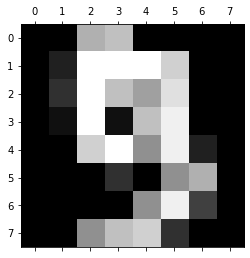

In [4]:
plt.gray()
plt.matshow(digits.images[9])
plt.show()

#### Write your code below

In [5]:
def label(Y):
    idx = np.argmax(Y, axis=1)
    a,b = np.shape(Y)
    for i in range(a):
        Y[i,:]=-1
        Y[i,idx[i]]=1
        
    return(Y)    

In [6]:
# Defining signum activation function
def signum(vec_w_x):
  """ signum activation for perceptron

  Parameters
  ------------
  vec_w_x: ndarray
    Weighted inputs
  """

  vec_w_x[vec_w_x >= 0] = 1
  vec_w_x[vec_w_x < 0] = -1
  return vec_w_x

In [7]:
# Perceptron training algorithm
def MultiClass_perceptron_train(X_train, Y_train, weights, learning_rate=1, total_epochs=100):
#   """Training method for Perceptron.
  
#   Parameters
#   -----------

#   X_train: ndarray (num_examples(rows) vs num_features(columns)) (1257,65) : including bias 1 with 64 features
#     Input dataset which perceptron will use to learn optimal weights
  
#   Y_train: ndarray (num_examples(rows) vs class_labels(columns))(1257,10)
#     Class labels for input data

#   weights: ndarray (num_features vs n_output)(65,10)
#     Weights used to train the network and predict on test set

#   learning_rate: int
#     Learning rate use to learn and update weights
  
#   total_epochs: int
#     Max number of epochs to train the perceptron model
#   """

    n_samples, _ = np.shape(X_train)
    history_weights = []
    epoch = 1

  # Number of missclassified points we would like to see in the train set.
  # While training, its value will change every epoch. If m==0, our training 
  # error will be zero.
    m = 1

  # If the most recent weights gave 0 misclassifications, break the loop.
  # Else continue until total_epochs is completed.
    while m != 0 and epoch <= total_epochs:
        m = 0

        # Compute weighted inputs and predict class labels on training set.
        weights_transpose_x = np.dot(X_train, weights) #(1257,65)*(65,10)=(1257,10) including the bias
        #weights_transpose_x = signum(weights_transpose_x)  #(1257,10) including the bias
        #y_train_out = np.multiply(Y_train, weights_transpose_x)  #(1257,10).*(1257,10) : elementwise multiplication
        epoch += 1
        
        # weight is a Column_Vec of 65x1 and X_train = row vector 1x65
        # If the predicted output label is the same as true label then weights are not updated.
        # However, when predicted output label  ≠  true label, then the wrongly classified 
        # input example is added to the weights of the correct label and subtracted from the weights of the incorrect label.
        
        y_pred=label(weights_transpose_x)
        
        for i in range(n_samples):
            pred_label = np.ravel(np.argwhere(y_pred[i] == 1))
            actual_label = np.ravel(np.argwhere(Y_train[i] == 1))
            if pred_label != actual_label:
                m += 1
                sample = np.reshape(X_train[i,:].T,(-1,1))
                #print(pred_label,actual_label,weights[:,pred_label].shape,sample.shape)
                weights[:,pred_label] -= (learning_rate) * sample
                weights[:,actual_label] += (learning_rate) * sample
                
        weights = np.round(weights, decimals=4)
        print('no. of samples misclassified ',m,'in epoch',epoch-1)

        # Append weights to visualize decision boundary later
        history_weights.append(weights)

    if m == 0 and epoch <= total_epochs:
        print("Training has stabilized with all points classified in : ", epoch-1,'epochs')
    else:
        print(f'Training completed at {epoch-1} epochs. {m} misclassified points remain.')

    return history_weights

In [8]:
# Evaluation for train, val, and test set.
def get_accuracy(y_predicted, Y_input_set, num_datapoints):
  miscls_points = np.argwhere(np.any(y_predicted != Y_input_set, axis=1))
  miscls_points = np.unique(miscls_points)
  accuracy = (1-len(miscls_points)/num_datapoints)*100
  return accuracy

def get_prediction(X_input_set, Y_input_set, weights, get_acc=False, model_type='perceptron', predict='no'):

  if len(Y_input_set) != 0:
    num_datapoints, num_categories = np.shape(Y_input_set)

  vec_w_transpose_x = np.dot(X_input_set, weights)

  if num_categories > 1: # Multi-class
    if model_type == 'perceptron':
      y_pred_out = multi_class_signum(vec_w_transpose_x)
    elif model_type == 'logreg':
      y_pred_out = softmax(X_input_set, vec_w_transpose_x, predict=predict)

  else: # Binary class
    if model_type == 'perceptron' or model_type == 'LinearDA':
      y_pred_out = signum(vec_w_transpose_x)
    elif model_type == 'logreg':
      y_pred_out = sigmoid(vec_w_transpose_x, predict=predict)

  # Both prediction and evaluation
  if get_acc:
    cls_acc = get_accuracy(y_pred_out, Y_input_set, num_datapoints)
    return cls_acc, y_pred_out
  
  # Only prediction
  return y_pred_out
# multi-class signum
def multi_class_signum(vec_w_x):
  """ Multiclass signum activation.

  Parameters
  ------------
  vec_w_x: ndarray
    Weighted inputs
  """

  flag = np.all(vec_w_x == 0)

  if flag:
    return vec_w_x

  else:
    num_examples, num_outputs = np.shape(vec_w_x)
    range_examples = np.array(range(0, num_examples))

    zero_idxs = np.argwhere(np.all(vec_w_x == 0, axis=1))
    non_zero_examples = np.delete(range_examples, zero_idxs[:, 0])
      
    signum_vec_w_x = vec_w_x[non_zero_examples]
    maxvals = np.amax(signum_vec_w_x, axis=1)
    
    for i in range(num_examples):
      idx = np.argwhere(signum_vec_w_x == maxvals[i])[0]
      signum_vec_w_x[idx[0], idx[1]] = 1

    non_maxvals_idxs = np.argwhere(signum_vec_w_x != 1)
    signum_vec_w_x[non_maxvals_idxs[:, 0], non_maxvals_idxs[:, 1]] = -1
    vec_w_x[non_zero_examples] = signum_vec_w_x

    return vec_w_x

In [9]:
# Initializing weights with normally distributed numbers between 0 and 1 
_, n_features = np.shape(X_train)
_, n_outputs = np.shape(Y_train)

#weights = np.zeros((n_features, n_outputs))
weights = np.random.normal(0, 1, (n_features, n_outputs))

In [10]:
trained_weights = MultiClass_perceptron_train(X_train, Y_train, weights, learning_rate=0.1, total_epochs=1000)

no. of samples misclassified  1140 in epoch 1
no. of samples misclassified  540 in epoch 2
no. of samples misclassified  1143 in epoch 3
no. of samples misclassified  974 in epoch 4
no. of samples misclassified  876 in epoch 5
no. of samples misclassified  982 in epoch 6
no. of samples misclassified  767 in epoch 7
no. of samples misclassified  668 in epoch 8
no. of samples misclassified  811 in epoch 9
no. of samples misclassified  839 in epoch 10
no. of samples misclassified  675 in epoch 11
no. of samples misclassified  537 in epoch 12
no. of samples misclassified  472 in epoch 13
no. of samples misclassified  405 in epoch 14
no. of samples misclassified  220 in epoch 15
no. of samples misclassified  132 in epoch 16
no. of samples misclassified  173 in epoch 17
no. of samples misclassified  207 in epoch 18
no. of samples misclassified  198 in epoch 19
no. of samples misclassified  168 in epoch 20
no. of samples misclassified  146 in epoch 21
no. of samples misclassified  123 in epoc

no. of samples misclassified  5 in epoch 182
no. of samples misclassified  6 in epoch 183
no. of samples misclassified  9 in epoch 184
no. of samples misclassified  6 in epoch 185
no. of samples misclassified  7 in epoch 186
no. of samples misclassified  6 in epoch 187
no. of samples misclassified  7 in epoch 188
no. of samples misclassified  16 in epoch 189
no. of samples misclassified  18 in epoch 190
no. of samples misclassified  14 in epoch 191
no. of samples misclassified  6 in epoch 192
no. of samples misclassified  5 in epoch 193
no. of samples misclassified  4 in epoch 194
no. of samples misclassified  8 in epoch 195
no. of samples misclassified  11 in epoch 196
no. of samples misclassified  15 in epoch 197
no. of samples misclassified  17 in epoch 198
no. of samples misclassified  17 in epoch 199
no. of samples misclassified  13 in epoch 200
no. of samples misclassified  13 in epoch 201
no. of samples misclassified  11 in epoch 202
no. of samples misclassified  11 in epoch 203

In [11]:
best_weights = trained_weights[-1]
train_acc, _ = get_prediction(X_train, Y_train, best_weights, get_acc=True)
val_acc, _ = get_prediction(X_val, Y_val, best_weights, get_acc=True)
test_acc, _ = get_prediction(X_test, Y_test, best_weights, get_acc=True)

print("Evaluation results")
print("Training accuracy: {:.3f}" .format(train_acc))
print("Validation accuracy: {:.3f}" .format(val_acc))
print("Test accuracy: {:.3f}" .format(test_acc))

Evaluation results
Training accuracy: 100.000
Validation accuracy: 94.444
Test accuracy: 95.556
